<h1 align='center'> Análisis de variación en ponderación de pesos en mecanismos de atención de Redes Neuronales Recurrentes en la predicción de sentimientos </h1>
<hr style="height:2px;border:none"/>

Desarrollado por: Kevin Reyes
## Índice del documento
### [1. Introducción](#Introducción)
### [2. Librerías Requeridas](#Librerías-Requeridas)
### [3. Fijación de Semillas](#Fijación-de-semillas)
### [4. Preprocesamiento de datos de texto](#Preprocesamiento-de-datos-de-texto)
### [5. Capa de atención personalizada](#Capa-de-atención-personalizada)
### [6. Entrenamiento de la red con mecanismo de atención tradicional](#Entrenamiento-de-la-red-con-mecanismo-de-atención-tradicional)  
### [7. Testing de red entrenada con variación en ponderación de pesos de la capa de atención](#Testing-de-red-entrenada-con-variación-en-ponderación-de-pesos-de-la-capa-de-atención)  
### [8. Resultados del experimento](#Resultados-del-experimento)  
### [9. Análisis de los resultados](#Análisis-de-los-resultados)  
### [9. Conclusión](#Conclusión)  


<hr style="height:2px;border:none"/>

**Referencia:**
Código base extraído de: https://matthewmcateer.me/blog/getting-started-with-attention-for-classification/



# Introducción
<br>
<div class=text-justify> 
Desde que la capacidad de cómputo disponible llego a un nivel óptimo para utilizar algoritmos de Redes Neuronales para aplicaciones reales, han surgido múltiples modificaciones a las ANN (Artificial Neural Network) tradicionales fruto de largos procesos de investigación y teoría desarrollada desde el siglo pasado, logrando así, poner a disposición de la comunidad científica y la sociedad, herramientas matemáticas, estadísticas y computacionales cada vez más especializadas. Muchas de estas ideas han sido inspiradas en investigación en el campo de la neurociencia. Uno de los campos más relevantes de la IA es el NLP (Natural Language Processing), el cual busca resolver problemas que tienen relación con la comprensión de lenguajes, más específicamente, que los computadores puedan comunicarse en el lenguaje natural de los humanos, de esta necesidad surgen las <b>Redes Neuronales Recurrentes</b>, las cuales buscan encontrar las relaciones secuenciales inherentes que poseen las sentencias de texto, audio, imágenes, etcétera, la idea base de estas redes es que en una secuencia, cuando se desea realizar una predicción o análisis sobre una palabra específica en alguna ubicación de la sentencia, esta predicción depende del contexto, es decir, las palabras (caso procesamiento de textos) que rodean estas sentencias. Sin embargo, todas estas posibles relaciones que pueden existir entre un dato en un tiempo t y tiempos t+x futuros o t-x pasados, pueden resultar en una alta complejidad, y probablemente estaremos considerando ciertas relaciones (t->t-x) que no aportan a una correcta  enpredicción, por esto último, aparece el mecanismo de <b>Atención en redes neuronales recurrentes</b><br>
    
La idea tras el mecanismo de atención, es que durante el entrenamiento la red aprenda en que parte de la sentencia, es decir, en que instantes de tiempo se debe fijar más para realizar una predicción correcta, por ejemplo, para predecir el sentimiento asociado a una palabra en específico en una sentencia, la red aprenderá a otorgar distintos pesos a las palabras que conformar la sentencia al momento de tomar la decisión.<br> <br>
En el presente documento, se analiza como afecta en el rendimiento de la red el aumentar o disminuir la ponderación de los pesos más importantes en una RNN con atención ya entrenada.
    
</div>

# Librerías Requeridas

In [1]:
import random as rn
import os
import numpy as np

os.environ["PYTHONHASHSEED"] = "0"
np.random.seed(1)
rn.seed(1)
from importlib import reload
import sys
from imp import reload
import warnings

warnings.filterwarnings("ignore")
if sys.version[0] == "2":
    reload(sys)
PYTHONIOENCODING = "UTF-8"

import nltk

nltk.download("stopwords")
nltk.download("wordnet")

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Input,
    LSTM,
    Embedding,
    Dropout,
    Activation,
    GRU,
    Flatten,
)
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\linco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\linco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
tf.compat.v1.set_random_seed(1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


# Fijación de semillas
<br>
<div class=text-justify> 
Un problema recurrente al momento de analizar y comparar distintas arquitecturas de redes es la naturaleza estocástica de los algoritmos utilizados, para minimizar este problema, se fijaron las semillas de Numpy, Tensorflow y Random de python, sin embargo, aún quedan componentes estocásticas que provienen de partes específicas de las arquitecturas de las redes entrenadas.
</div>

# Preprocesamiento de datos de texto

1. Llevamos los tags de 'pos' y 'neg' a 1 y 0 respectivamente.
2. Limpiamos exceso de espacios en blancos y carácteres alfanuméricos.
3. Llevamos cada sentencia a minúscula.
4. Tokenizamos las sentencias.
5. Aplicamos lemmatizer (reducimos palabras a una raíz común).
6. Volvemos a unir todo el texto.
7. Aplicamos la función a toda la columna.

**Se visualiza tabla con el sentimiento asociado al texto sin procesar y ya procesado.**

In [3]:
import pandas as pd

df1 = pd.read_csv("labeledTrainData.tsv", delimiter="\t")
df1 = df1.drop(["id"], axis=1)
df2 = pd.read_csv("imdb_master.csv", encoding="latin-1")
df2 = df2.drop(["Unnamed: 0", "type", "file"], axis=1)
df2.columns = ["review", "sentiment"]
df2 = df2[df2.sentiment != "unsup"]
df2["sentiment"] = df2["sentiment"].map({"pos": 1, "neg": 0})
df = pd.concat([df1, df2]).reset_index(drop=True)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r"[^\w\s]", "", text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text


df["Processed_Reviews"] = df.review.apply(lambda x: clean_text(x))
df.head()


,sentiment,review,Processed_Reviews
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


### Embedding


Las redes neuronales no procesan textos, sino que, procesan datos numéricos, por lo anterior, es habitual llevar palabras a representaciones, tales como: one-hot-vetor, la cual consiste en un arreglo del largo del diccionario de palabras a utilizar (es decir, todas las palabras presentes en el dataset), donde en cada posición $i$ se indica con 1 o 0 si es la palabra $i$ de diccionario, tal representación es realmente ineficiente, ya que, requiere de una memoria excesiva y aumenta los tiempos de cómputo. Existen otras representaciones más eficientes, por ejemplo, **Word Embedding**, la idea de este algoritmo es mapear cada palabra a un vector n-dimensional, esto trae múltiples ventajas, ya que, se pueden armar clusters de palabras en el espacio n-dimensional, guardando información de las relaciones entre palabras, como que tan cercana es una palabra a otra en significado.

###  Creación de sequencias

- Definimos el diccionario para el embedding
- Llevamos el texto a secuencias
- Estandarizamos el largo de las sequencias
- Preparamos los conjuntos de entrenamiento y testing

In [4]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df["Processed_Reviews"])
list_tokenized_train = tokenizer.texts_to_sequences(df["Processed_Reviews"])

RNN_CELL_SIZE = 32

MAX_LEN = 130  # Since our mean length is 128.5
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = df["sentiment"]


In [5]:
# Loading the test dataset, and repeating the processing steps
df_test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"] = df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(
    lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0
)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_test = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)


# Capa de atención personalizada
Se estudiará el comportamiento del vector de contexto (context_vector) al modificar la componente attention_weights bajo una alteración exponencial
<br>
- Cálculo original:
$$ context\_vector = \alpha * features $$

- Modificación de ponderación de pesos:

$$ context\_vector = \frac{\alpha^{q}}{\sum_j \alpha^q} * features $$

**Casos:**
1. q=1 : Mecanismo de atención tradicional
2. q<1 : Se quita importancia a las partes de la sentencia que la red aprendió a dar mayor atención.
3. q>1 : Se aumenta la importante a las partes de la sentencia que la red aprendió a dar mayor atención y se le quita importancia a las con menos atención.

In [6]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden, q):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        # context_vector = attention_weights * features
        ### Añadiendo exponente para estudiar comportamiento de los pesos
        # context_vector = tf.math.pow(attention_weights,q) * features
        attention_q = tf.math.pow(attention_weights, q)
        context_vector = (
            attention_q / tf.reduce_sum(attention_q, axis=1, keepdims=True)
        ) * features  # 0.765
        # context_vector = (attention_q/tf.reduce_sum(attention_q)) * features #0.765
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


# Entrenamiento de la red con mecanismo de atención tradicional
La siguiente celda permanecerá comentada, ya que, los pesos fueron guardados en "initial_model_weights.h5' y el entrenamiento toma bastante tiempo, de esta manera podemos proceder a analizar la red para testear bajo variaciones del valor de q.

In [7]:
## Seteamos la semillas apra evitar el comportamiento estocástico
#
## 0.81 sin valor q
# BATCH_SIZE = 100
# EPOCHS = 5
#
#
# sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
# embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
## Getting our LSTM outputs
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)
# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])
# context_vector, attention_weights = Attention(10)(lstm, state_h,1)
# dense1 = Dense(20, activation="relu")(context_vector)
# dropout = Dropout(0.05)(dense1)
# output = Dense(1, activation="sigmoid")(dropout)
# model = keras.Model(inputs=sequence_input, outputs=output)
# METRICS = [
#    keras.metrics.TruePositives(name='tp'),
#    keras.metrics.FalsePositives(name='fp'),
#    keras.metrics.TrueNegatives(name='tn'),
#    keras.metrics.FalseNegatives(name='fn'),
#    keras.metrics.BinaryAccuracy(name='accuracy'),
#    keras.metrics.Precision(name='precision'),
#    keras.metrics.Recall(name='recall'),
#    keras.metrics.AUC(name='auc'),
# ]
#
# model.compile(loss='binary_crossentropy',
#              optimizer='adam',
#              metrics=METRICS)
#
# history = model.fit(X_train,y_train,
#                    batch_size=BATCH_SIZE,
#                    epochs=EPOCHS,
#                    validation_split=0.2,verbose=0)
# model.save_weights('initial_model_weights.h5')


# Testing de red entrenada con variación en ponderación de pesos de la capa de atención

Si bien el entrenamiento de una red es inherentemente estocástico, al momento de utilizar la red para realizar una predicción, para una misma entrada tendremos el mismo resultado en cada ejecución, esto nos es realmente útil para estudiar las variaciones en el mecanismo de atención. Se destaca que los pesos óptimos para minimizar los errores de entrenamiento y validación fueron encontrados con el entrenamiento y ajuste de hiperparámetros de la red, por lo que, las variaciones en la atención permitirán estudiar el comportamiento de la red en datos que nunca ha observado, por lo tanto, los resultados obtenidos corresponden a la capacidad de generalización de la red dependiendo de la ponderación de pesos de la capa de atención.

In [8]:
BATCH_SIZE = 100
EPOCHS = 5
## Metricas a graficar
accuracies = []
F1s_wa = []
precisions_wa = []
recalls_wa = []
F1s_mia = []
precisions_mia = []
recalls_mia = []
F1s_ma = []
precisions_ma = []
recalls_ma = []

qs = [-8, -4, -1, -0.4, 0, 0.5, 0.99, 1, 1.001, 1.35, 1.5, 2, 4, 8, 10]
# qs = [1.2,1.25,1.27,1.3,1.31, 1.32, 1.35, 1.37, 1.39 ,1.4]

for q in qs:
    sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
    embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
    lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_0")(
        embedded_sequences
    )
    # Getting our LSTM outputs
    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(
        LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1"
    )(lstm)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    context_vector, attention_weights = Attention(10)(lstm, state_h, q)
    dense1 = Dense(20, activation="relu")(context_vector)
    dropout = Dropout(0.05)(dense1)
    output = Dense(1, activation="sigmoid")(dropout)
    model2 = keras.Model(inputs=sequence_input, outputs=output)

    model2.load_weights("initial_model_weights.h5")
    prediction = model2.predict(X_test)
    y_pred = prediction > 0.5
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracies.append(report["accuracy"])

    precisions_wa.append(report["weighted avg"]["precision"])
    recalls_wa.append(report["weighted avg"]["recall"])
    F1s_wa.append(report["weighted avg"]["f1-score"])

    # precisions_mia.append(report["micro avg"]["precision"])
    # recalls_mia.append(report["micro avg"]["recall"])
    # F1s_mia.append(report["micro avg"]["f1-score"])

    precisions_ma.append(report["macro avg"]["precision"])
    recalls_ma.append(report["macro avg"]["recall"])
    F1s_ma.append(report["macro avg"]["f1-score"])
    print(f'El valor de q actual es: {q} con accuracy de: {report["accuracy"]} \n')


El valor de q actual es: -8 con accuracy de: 0.59868 

El valor de q actual es: -4 con accuracy de: 0.60864 

El valor de q actual es: -1 con accuracy de: 0.64908 

El valor de q actual es: -0.4 con accuracy de: 0.70436 

El valor de q actual es: 0 con accuracy de: 0.86112 

El valor de q actual es: 0.5 con accuracy de: 0.95596 

El valor de q actual es: 0.99 con accuracy de: 0.96784 

El valor de q actual es: 1 con accuracy de: 0.96792 

El valor de q actual es: 1.001 con accuracy de: 0.96796 

El valor de q actual es: 1.35 con accuracy de: 0.9696 

El valor de q actual es: 1.5 con accuracy de: 0.969 

El valor de q actual es: 2 con accuracy de: 0.96796 

El valor de q actual es: 4 con accuracy de: 0.96104 

El valor de q actual es: 8 con accuracy de: 0.95544 

El valor de q actual es: 10 con accuracy de: 0.95436 



In [9]:
(0.9696 - 0.96792) / 0.96792


0.0017356806347632188

# Resultados del experimento

- Precision = Representa la habilidad de un clasificador de no predecir como positivo un valor negativo  
<br>
$$ Precision = \frac{tp}{tp + fp} $$  
<br>
- Recall = Representa la habilidad de un clasificador de reconocer eficazmente todos los ejemplos positivos  
<br>
$$ Recall = \frac{tp}{tp + fn} $$  
<br>
- F1 Score = Combina las métricas de precision y recall, se puede modificar para ponderar más una métrica u otra  
<br>
$$ F1 Score =  2*\frac{precision*recall}{precision + recall} $$  
<br>
- macro = Calcula las métricas para cada label, y calcula la media no ponderada (No toma en cuenta el desbalanceo de clases)
- Weighted average = Calculas las métricas considerando la ponderación por apariciones de los valores positivos en el dataset (Toma en cuenta el desbalanceo de clases)

Text(0.5, 1.0, 'F1 vs Q Macro Average')

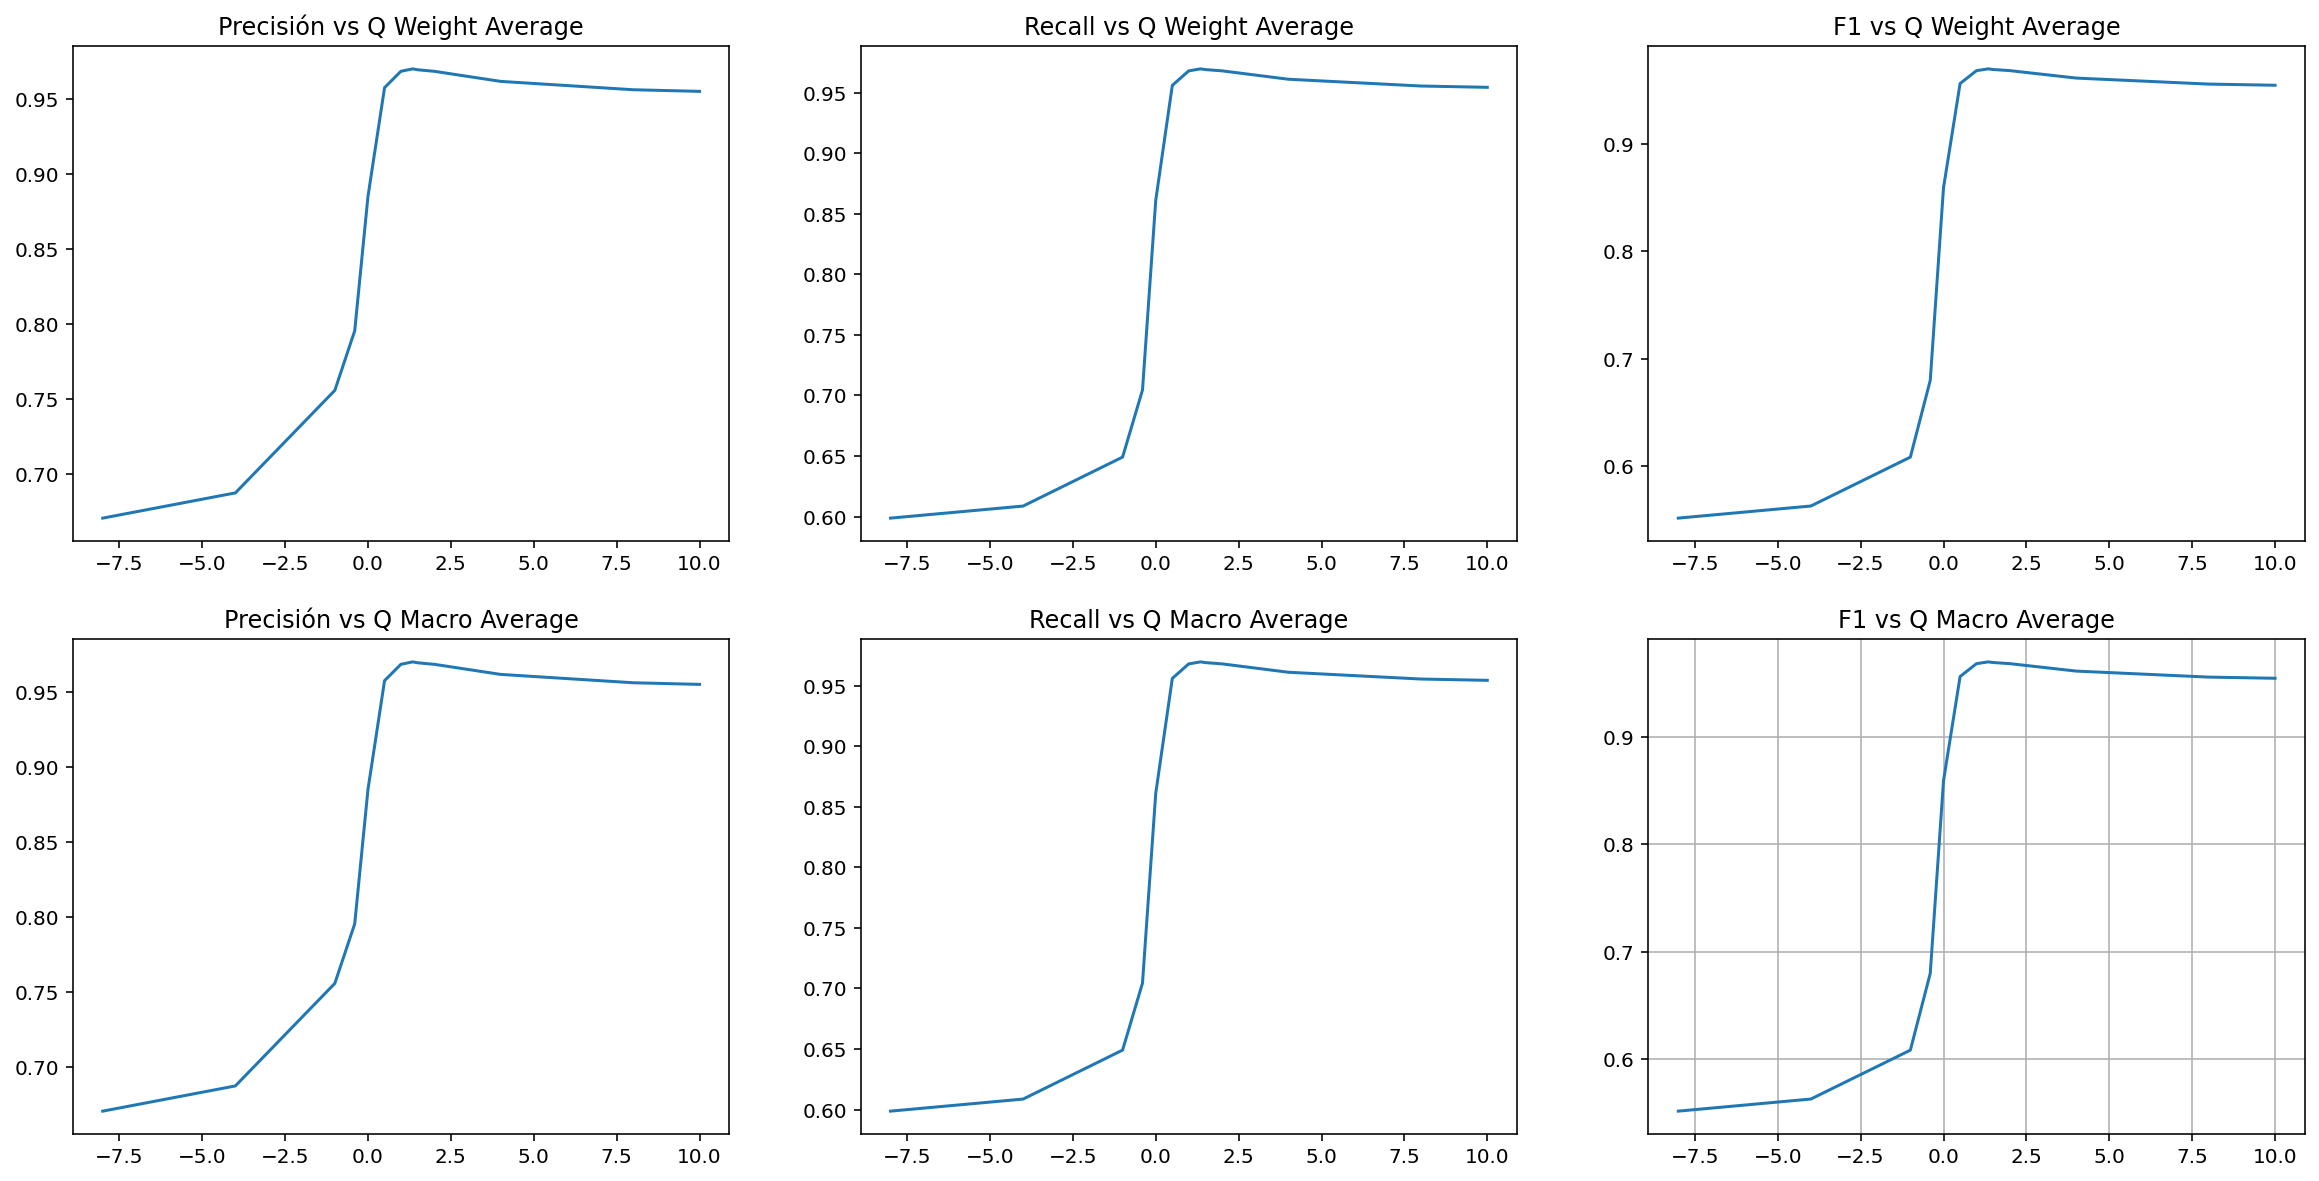

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.grid(True)
axs[0, 0].plot(qs, precisions_wa)
axs[0, 0].set_title("Precisión vs Q Weight Average")
axs[0, 1].plot(qs, recalls_wa)
axs[0, 1].set_title("Recall vs Q Weight Average")
axs[0, 2].plot(qs, F1s_wa)
axs[0, 2].set_title("F1 vs Q Weight Average")
axs[1, 0].plot(qs, precisions_ma)
axs[1, 0].set_title("Precisión vs Q Macro Average")
axs[1, 1].plot(qs, recalls_ma)
axs[1, 1].set_title("Recall vs Q Macro Average")
axs[1, 2].plot(qs, F1s_ma)
axs[1, 2].set_title("F1 vs Q Macro Average")


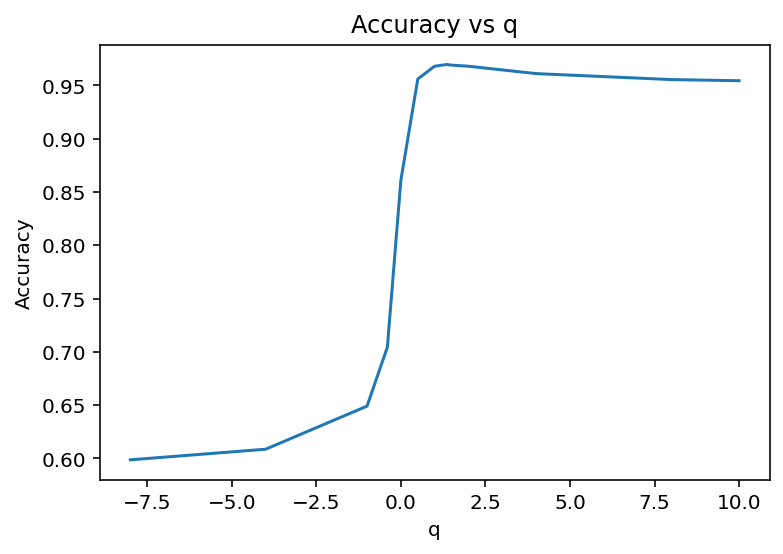

In [11]:
plt.plot(qs, accuracies)
plt.title("Accuracy vs q")
plt.ylabel("Accuracy")
plt.xlabel("q")
plt.show()


### Evaluando en Data de entrenamiento

In [13]:
BATCH_SIZE = 100
EPOCHS = 5
## Metricas a graficar
accuracies = []
F1s_wa = []
precisions_wa = []
recalls_wa = []
F1s_mia = []
precisions_mia = []
recalls_mia = []
F1s_ma = []
precisions_ma = []
recalls_ma = []

qs = [-1, -0.4, 0, 0.5, 0.99, 1, 1.001, 1.35, 1.5, 2, 4]

# qs = [1.2,1.25,1.27,1.3,1.31, 1.32, 1.35, 1.37, 1.39 ,1.4]

for q in qs:
    sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
    embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
    lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_0")(
        embedded_sequences
    )
    # Getting our LSTM outputs
    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(
        LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1"
    )(lstm)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    context_vector, attention_weights = Attention(10)(lstm, state_h, q)
    dense1 = Dense(20, activation="relu")(context_vector)
    dropout = Dropout(0.05)(dense1)
    output = Dense(1, activation="sigmoid")(dropout)
    model2 = keras.Model(inputs=sequence_input, outputs=output)

    model2.load_weights("initial_model_weights.h5")
    prediction = model2.predict(X_train)
    y_pred = prediction > 0.5
    report = classification_report(y_train, y_pred, output_dict=True)
    accuracies.append(report["accuracy"])

    precisions_wa.append(report["weighted avg"]["precision"])
    recalls_wa.append(report["weighted avg"]["recall"])
    F1s_wa.append(report["weighted avg"]["f1-score"])

    # precisions_mia.append(report["micro avg"]["precision"])
    # recalls_mia.append(report["micro avg"]["recall"])
    # F1s_mia.append(report["micro avg"]["f1-score"])

    precisions_ma.append(report["macro avg"]["precision"])
    recalls_ma.append(report["macro avg"]["recall"])
    F1s_ma.append(report["macro avg"]["f1-score"])
    print(f'El valor de q actual es: {q} con accuracy de: {report["accuracy"]} \n')


El valor de q actual es: -1 con accuracy de: 0.6497466666666667 

El valor de q actual es: -0.4 con accuracy de: 0.7055866666666667 

El valor de q actual es: 0 con accuracy de: 0.8697866666666667 

El valor de q actual es: 0.5 con accuracy de: 0.9628 

El valor de q actual es: 0.99 con accuracy de: 0.9743866666666666 

El valor de q actual es: 1 con accuracy de: 0.97432 

El valor de q actual es: 1.001 con accuracy de: 0.97436 

El valor de q actual es: 1.35 con accuracy de: 0.9751733333333333 

El valor de q actual es: 1.5 con accuracy de: 0.9747333333333333 

El valor de q actual es: 2 con accuracy de: 0.9742 

El valor de q actual es: 4 con accuracy de: 0.9671733333333333 



Text(0.5, 1.0, 'F1 vs Q Macro Average')

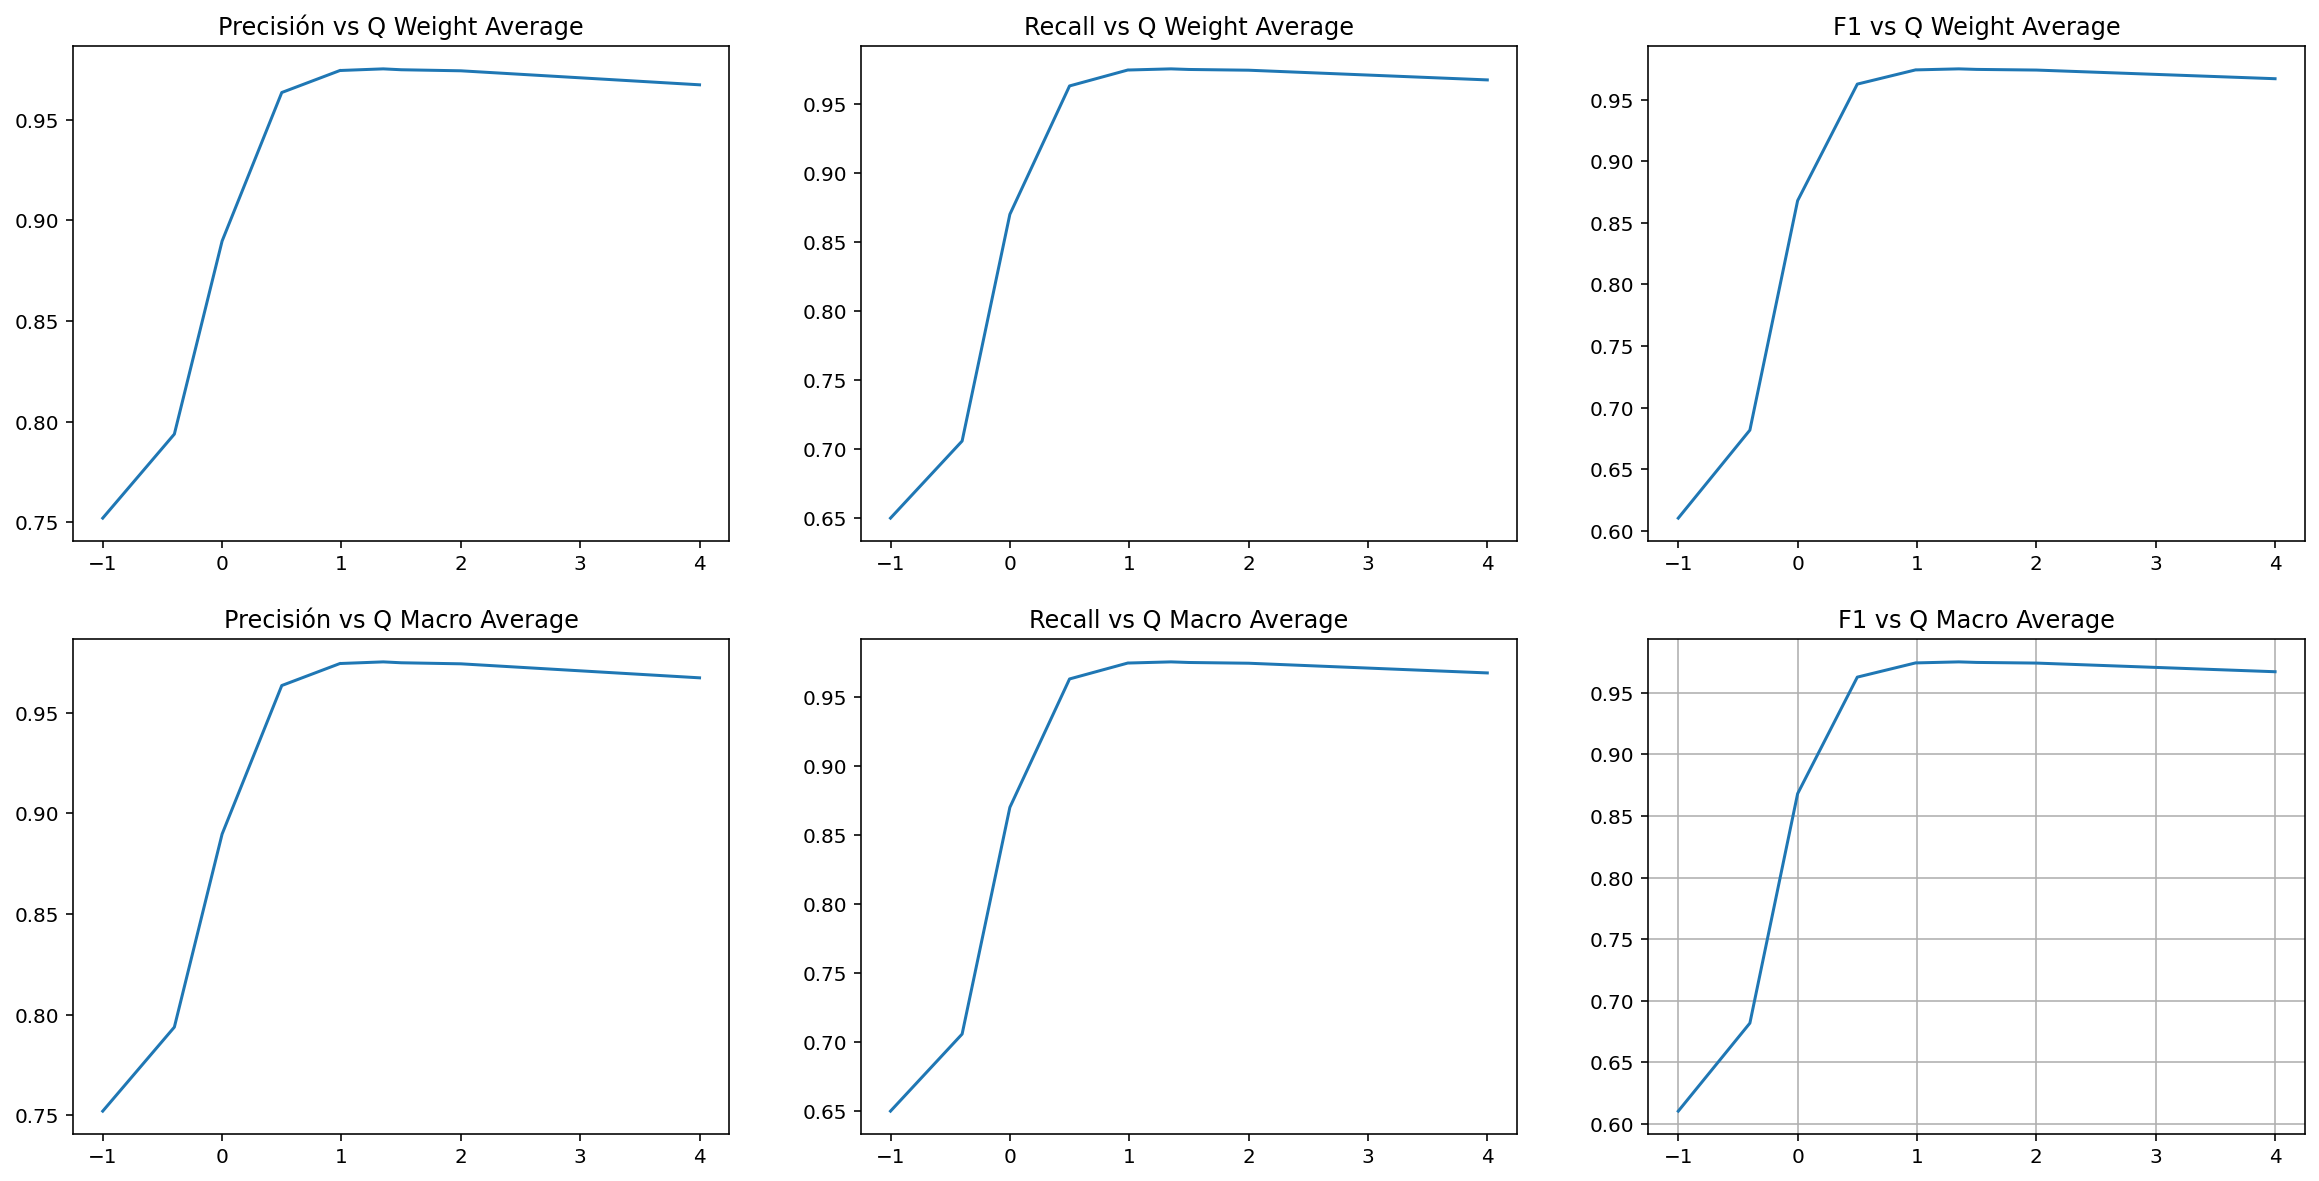

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.grid(True)
axs[0, 0].plot(qs, precisions_wa)
axs[0, 0].set_title("Precisión vs Q Weight Average")
axs[0, 1].plot(qs, recalls_wa)
axs[0, 1].set_title("Recall vs Q Weight Average")
axs[0, 2].plot(qs, F1s_wa)
axs[0, 2].set_title("F1 vs Q Weight Average")
axs[1, 0].plot(qs, precisions_ma)
axs[1, 0].set_title("Precisión vs Q Macro Average")
axs[1, 1].plot(qs, recalls_ma)
axs[1, 1].set_title("Recall vs Q Macro Average")
axs[1, 2].plot(qs, F1s_ma)
axs[1, 2].set_title("F1 vs Q Macro Average")


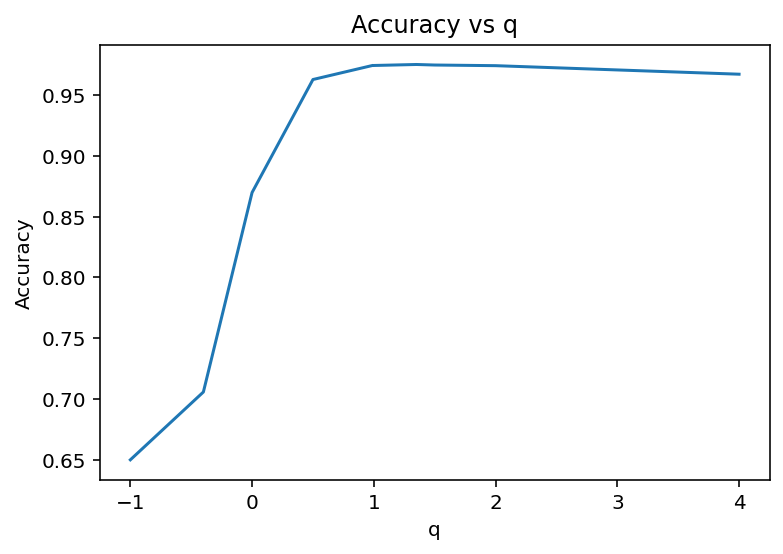

In [15]:
plt.plot(qs, accuracies)
plt.title("Accuracy vs q")
plt.ylabel("Accuracy")
plt.xlabel("q")
plt.show()


### Entrenamiento con Q=1.35

In [16]:
## Seteamos la semillas apra evitar el comportamiento estocástico
#
## 0.81 sin valor q
# BATCH_SIZE = 100
# EPOCHS = 5
#
#
# sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
# embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)
## Getting our LSTM outputs
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)
# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])
# context_vector, attention_weights = Attention(10)(lstm, state_h,1.35)
# dense1 = Dense(20, activation="relu")(context_vector)
# dropout = Dropout(0.05)(dense1)
# output = Dense(1, activation="sigmoid")(dropout)
# model = keras.Model(inputs=sequence_input, outputs=output)
# METRICS = [
#    keras.metrics.TruePositives(name='tp'),
#    keras.metrics.FalsePositives(name='fp'),
#    keras.metrics.TrueNegatives(name='tn'),
#    keras.metrics.FalseNegatives(name='fn'),
#    keras.metrics.BinaryAccuracy(name='accuracy'),
#    keras.metrics.Precision(name='precision'),
#    keras.metrics.Recall(name='recall'),
#    keras.metrics.AUC(name='auc'),
# ]
#
# model.compile(loss='binary_crossentropy',
#              optimizer='adam',
#              metrics=METRICS)
#
# history = model.fit(X_train,y_train,
#                    batch_size=BATCH_SIZE,
#                    epochs=EPOCHS,
#                    validation_split=0.2,verbose=0)
# model.save_weights('initial_model_weights_q_1_35.h5')


In [19]:
BATCH_SIZE = 100
EPOCHS = 5
## Metricas a graficar
accuracies = []
F1s_wa = []
precisions_wa = []
recalls_wa = []
F1s_mia = []
precisions_mia = []
recalls_mia = []
F1s_ma = []
precisions_ma = []
recalls_ma = []

qs = [-1, -0.4, 0, 0.5, 0.99, 1, 1.001, 1.35, 1.5, 2, 4]

# qs = [1.2,1.25,1.27,1.3,1.31, 1.32, 1.35, 1.37, 1.39 ,1.4]

for q in qs:
    sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
    embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
    lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_0")(
        embedded_sequences
    )
    # Getting our LSTM outputs
    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(
        LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1"
    )(lstm)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    context_vector, attention_weights = Attention(10)(lstm, state_h, q)
    dense1 = Dense(20, activation="relu")(context_vector)
    dropout = Dropout(0.05)(dense1)
    output = Dense(1, activation="sigmoid")(dropout)
    model2 = keras.Model(inputs=sequence_input, outputs=output)

    model2.load_weights("initial_model_weights_q_1_35.h5")
    prediction = model2.predict(X_test)
    y_pred = prediction > 0.5
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracies.append(report["accuracy"])

    precisions_wa.append(report["weighted avg"]["precision"])
    recalls_wa.append(report["weighted avg"]["recall"])
    F1s_wa.append(report["weighted avg"]["f1-score"])

    # precisions_mia.append(report["micro avg"]["precision"])
    # recalls_mia.append(report["micro avg"]["recall"])
    # F1s_mia.append(report["micro avg"]["f1-score"])

    precisions_ma.append(report["macro avg"]["precision"])
    recalls_ma.append(report["macro avg"]["recall"])
    F1s_ma.append(report["macro avg"]["f1-score"])
    print(f'El valor de q actual es: {q} con accuracy de: {report["accuracy"]} \n')


El valor de q actual es: -1 con accuracy de: 0.72772 

El valor de q actual es: -0.4 con accuracy de: 0.83136 

El valor de q actual es: 0 con accuracy de: 0.91072 

El valor de q actual es: 0.5 con accuracy de: 0.95832 

El valor de q actual es: 0.99 con accuracy de: 0.97348 

El valor de q actual es: 1 con accuracy de: 0.97368 

El valor de q actual es: 1.001 con accuracy de: 0.97368 

El valor de q actual es: 1.35 con accuracy de: 0.9752 

El valor de q actual es: 1.5 con accuracy de: 0.97552 

El valor de q actual es: 2 con accuracy de: 0.97432 

El valor de q actual es: 4 con accuracy de: 0.96936 



Text(0.5, 1.0, 'F1 vs Q Macro Average')

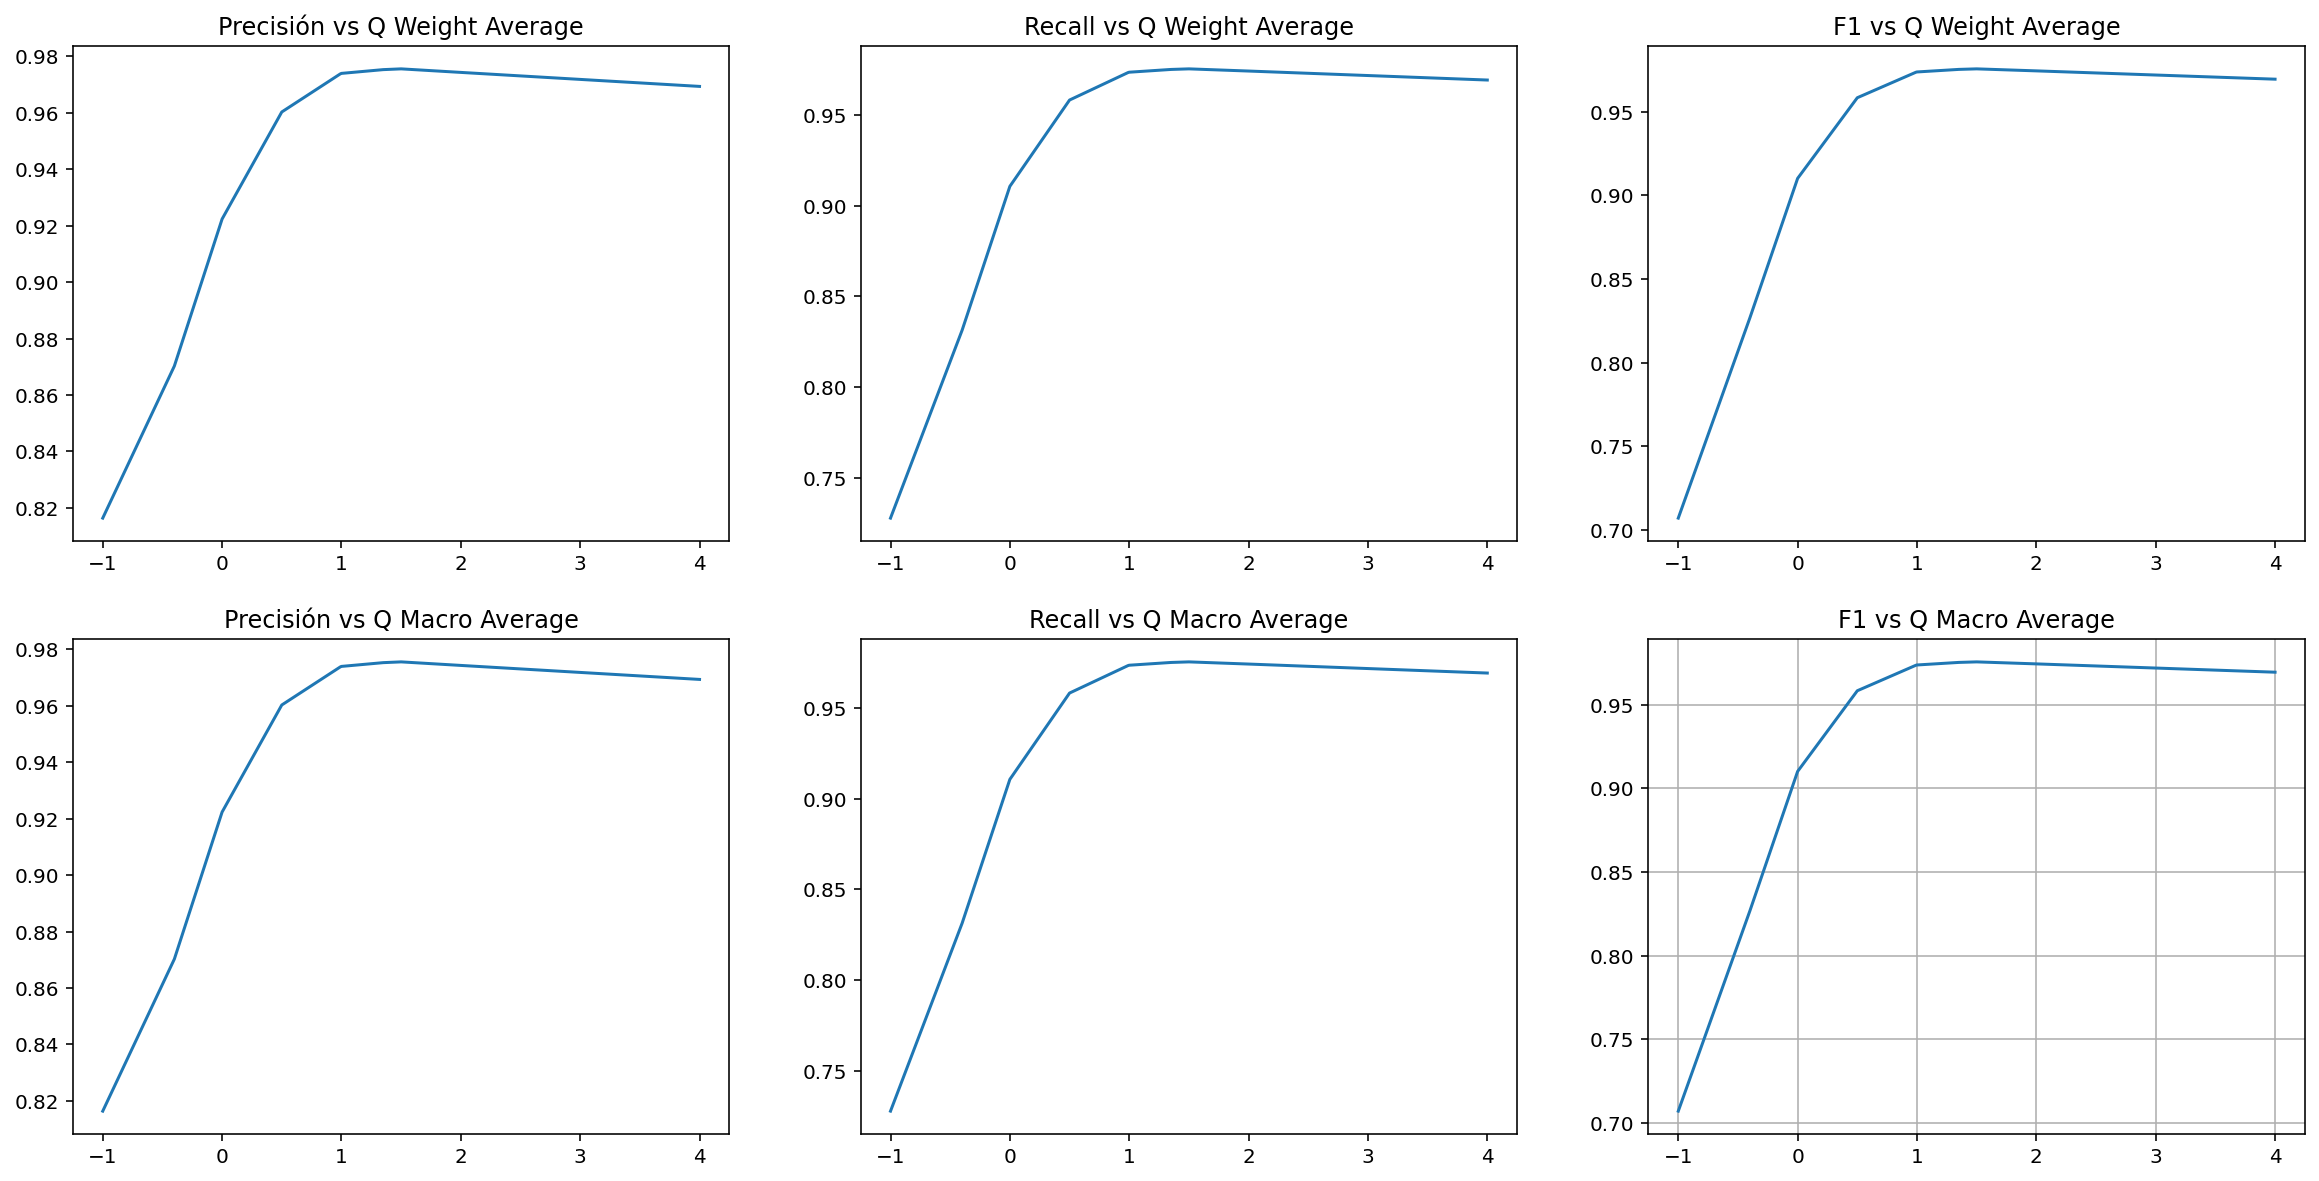

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.grid(True)
axs[0, 0].plot(qs, precisions_wa)
axs[0, 0].set_title("Precisión vs Q Weight Average")
axs[0, 1].plot(qs, recalls_wa)
axs[0, 1].set_title("Recall vs Q Weight Average")
axs[0, 2].plot(qs, F1s_wa)
axs[0, 2].set_title("F1 vs Q Weight Average")
axs[1, 0].plot(qs, precisions_ma)
axs[1, 0].set_title("Precisión vs Q Macro Average")
axs[1, 1].plot(qs, recalls_ma)
axs[1, 1].set_title("Recall vs Q Macro Average")
axs[1, 2].plot(qs, F1s_ma)
axs[1, 2].set_title("F1 vs Q Macro Average")


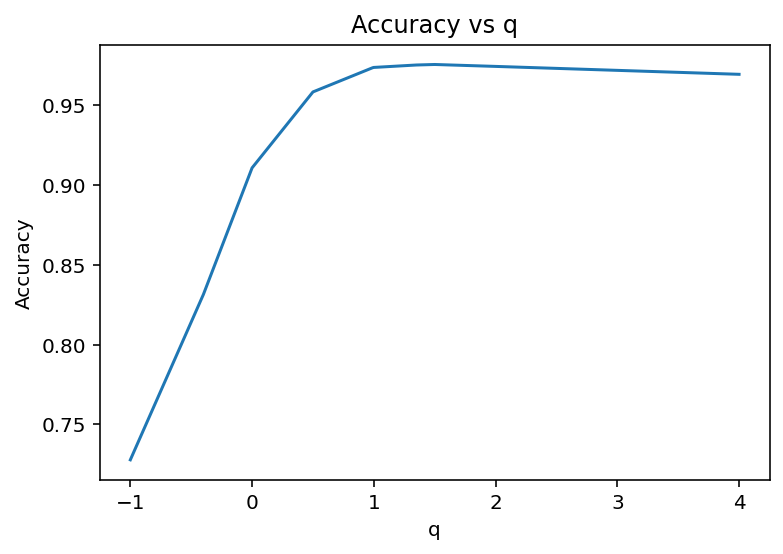

In [21]:
plt.plot(qs, accuracies)
plt.title("Accuracy vs q")
plt.ylabel("Accuracy")
plt.xlabel("q")
plt.show()


### Evaluando en Data de entrenamiento

In [23]:
BATCH_SIZE = 100
EPOCHS = 5
## Metricas a graficar
accuracies = []
F1s_wa = []
precisions_wa = []
recalls_wa = []
F1s_mia = []
precisions_mia = []
recalls_mia = []
F1s_ma = []
precisions_ma = []
recalls_ma = []

qs = [-1, -0.4, 0, 0.5, 0.99, 1, 1.001, 1.35, 1.5, 2, 4]

# qs = [1.2,1.25,1.27,1.3,1.31, 1.32, 1.35, 1.37, 1.39 ,1.4]

for q in qs:
    sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
    embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)
    lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_0")(
        embedded_sequences
    )
    # Getting our LSTM outputs
    (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(
        LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1"
    )(lstm)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    context_vector, attention_weights = Attention(10)(lstm, state_h, q)
    dense1 = Dense(20, activation="relu")(context_vector)
    dropout = Dropout(0.05)(dense1)
    output = Dense(1, activation="sigmoid")(dropout)
    model2 = keras.Model(inputs=sequence_input, outputs=output)

    model2.load_weights("initial_model_weights_q_1_35.h5")
    prediction = model2.predict(X_train)
    y_pred = prediction > 0.5
    report = classification_report(y_train, y_pred, output_dict=True)
    accuracies.append(report["accuracy"])

    precisions_wa.append(report["weighted avg"]["precision"])
    recalls_wa.append(report["weighted avg"]["recall"])
    F1s_wa.append(report["weighted avg"]["f1-score"])

    # precisions_mia.append(report["micro avg"]["precision"])
    # recalls_mia.append(report["micro avg"]["recall"])
    # F1s_mia.append(report["micro avg"]["f1-score"])

    precisions_ma.append(report["macro avg"]["precision"])
    recalls_ma.append(report["macro avg"]["recall"])
    F1s_ma.append(report["macro avg"]["f1-score"])
    print(f'El valor de q actual es: {q} con accuracy de: {report["accuracy"]} \n')


El valor de q actual es: -1 con accuracy de: 0.7328533333333334 

El valor de q actual es: -0.4 con accuracy de: 0.84012 

El valor de q actual es: 0 con accuracy de: 0.91988 

El valor de q actual es: 0.5 con accuracy de: 0.9656266666666666 

El valor de q actual es: 0.99 con accuracy de: 0.9793066666666667 

El valor de q actual es: 1 con accuracy de: 0.9794933333333333 

El valor de q actual es: 1.001 con accuracy de: 0.9794933333333333 

El valor de q actual es: 1.35 con accuracy de: 0.9808533333333334 

El valor de q actual es: 1.5 con accuracy de: 0.98052 

El valor de q actual es: 2 con accuracy de: 0.9785866666666667 

El valor de q actual es: 4 con accuracy de: 0.9726 



In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.grid(True)
axs[0, 0].plot(qs, precisions_wa)
axs[0, 0].set_title("Precisión vs Q Weight Average")
axs[0, 1].plot(qs, recalls_wa)
axs[0, 1].set_title("Recall vs Q Weight Average")
axs[0, 2].plot(qs, F1s_wa)
axs[0, 2].set_title("F1 vs Q Weight Average")
axs[1, 0].plot(qs, precisions_ma)
axs[1, 0].set_title("Precisión vs Q Macro Average")
axs[1, 1].plot(qs, recalls_ma)
axs[1, 1].set_title("Recall vs Q Macro Average")
axs[1, 2].plot(qs, F1s_ma)
axs[1, 2].set_title("F1 vs Q Macro Average")


In [ ]:
plt.plot(qs, accuracies)
plt.title("Accuracy vs q")
plt.ylabel("Accuracy")
plt.xlabel("q")
plt.show()


# Análisis de los resultados

- Se observa en las gráficas para valores negativos de q, es decir, se pone mayor atención a las palabras erróneas (las que la red aprendió a no dar mayor importancia en una predicción), lo cual provoca que las predicciones fallen constantementes.
- Se observa que a medida que el valor tiende a 0, es decir, un modelo de RNN bidireccional sin atención, la capacidad de la red aumenta considerablemente respecto de los valores negativos para q (atención inversa).
- Se observa que desde el modelo sin atención (q = 0) hasta un modelo con atención estándar (q = 1), el rendimiento de la red continúa aumentando.
- Luego del valor estándar (q = 1), el rendimiento sigue mejorando hasta un valor de q = 1.35, esta mejora es de: 0.17%. Posterior al valor de q = 1.35 el rendimiento del modelo vuelve a disminuir.

# Conclusión

Existe una mejora considerable en el rendimiento de Redes Neuronales Recurrentes Bidireccionales al añadir un mecanismo de atención en la tarea de predecir el sentimiento asociado a una sentencia. A medida que la red comienza a aprender los pesos de atención que debe asignar a las palabras, el rendimiento de la red en la predicción de sentimientos comienza a aumentar, posterior al aprendizaje, si se modifica la ponderación de forma de que aquellas palabras aprendidas como importantes por la red tengan un peso levemente mayor (q = 1.3) en la predicción, la red aumenta su rendimiento en la capacidad de generalización en un **0.17%**, lo anterior podría parecer insignificante, sin embargo, si hablamos de una API que debe recibir 1 millón de sentencias al día (bastante realista, de hecho podría ser mucho más) a las cuales predecir el sentimiento, estamos hablando de predecir correctamente aproximadamente $1.000.000*0.0017=1700$ sentencias adicionales, lo cuál, es un número considerable al momento de satisfacer a los clientes de una compañia.